In [ ]:
# Write code to fine-tune BERT to the IMDB dataset for sentiment analysis.
# Divide the training dataset into training/validation (90%/10%)
# Fine-tune for 10 epochs measuring the validation performance after each epoch. Visualize the performance in a plot.
# How many epochs takes to reach the best validation performance?
# Evaluate on the test dataset. How validation and test performances differ?
# https://huggingface.co/blog/sentiment-analysis-python
# install datasets
#!pip install datasets

In [122]:
#sentiment analysis fine tuning
from datasets import list_datasets, load_dataset

from pprint import pprint
# Currently available datasets
ds = load_dataset("stanfordnlp/imdb")

In [127]:

#ds_train = load_dataset("stanfordnlp/imdb", split='train[:90%]')
# ds_validation = load_dataset("stanfordnlp/imdb", split='train[-10%:]')

#ds_temp = load_dataset("stanfordnlp/imdb", split='train[:1%]')
#ds_test = load_dataset("stanfordnlp/imdb", split='test')
ds_train_split = ds['train'].train_test_split(test_size=0.1, seed=42)
ds_train = ds_train_split['train']
ds_validation = ds_train_split['test']
ds_validation_split = ds_validation.train_test_split(test_size=0.1, seed=42)
ds_temp = ds_validation_split['test']

#print(ds_train_split)
print(ds_train)
print(ds_validation)
print(ds_test)
print(ds_temp)


Dataset({
    features: ['text', 'label'],
    num_rows: 22500
})
Dataset({
    features: ['text', 'label'],
    num_rows: 2500
})
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 250
})


In [128]:
# But first see BERT tokenizer exmaples and other required stuff!
from transformers import AutoTokenizer, DataCollatorWithPadding
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
print(ds_validation)
# example='In this Kaggle notebook, I will do sentiment analysis using BERT with Huggingface'
# tokens=tokenizer.tokenize(example)
# token_ids = tokenizer.convert_tokens_to_ids(tokens)
# print(tokens)
# print(token_ids)

Dataset({
    features: ['text', 'label'],
    num_rows: 2500
})


/nfs/site/disks/ssm_rakram_001/venv_python39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [129]:
from transformers import AutoTokenizer, DataCollatorWithPadding

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_ds_train = ds_train.map(tokenize_function, batched=True)
tokenized_ds_validation = ds_validation.map(tokenize_function, batched=True)
tokenized_ds_test = ds_test.map(tokenize_function, batched=True)
tokenized_ds_temp = ds_temp.map(tokenize_function, batched=True)
print(tokenized_ds_temp)
print(tokenized_ds_temp.features)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 250
})
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [130]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_metric
import numpy as np
print(tokenized_ds_temp2)
print(tokenized_ds_temp)
# def compute_metrics(eval_preds):
# #     metric = evaluate.load("glue", "mrpc")
#     metric = load_metric("accuracy")
#     logits, labels = eval_preds
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
  
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 250
})
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 250
})


In [144]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    push_to_hub=False,
)
#training_args = TrainingArguments("test-trainer")
#print(training_args)
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_validation,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Fine-tune the model
trainer.train()

# Evaluate the fine-tuned model
results = trainer.evaluate()

# Print evaluation results
print(results)

/nfs/site/disks/ssm_rakram_001/venv_python39/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.12.14, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.235600,0.082643,0.973200,0.972973
2,0.155100,0.081989,0.974800,0.974770
3,0.087300,0.114733,0.973200,0.973211
4,0.046700,0.109293,0.975200,0.975279
5,0.039000,0.171982,0.971600,0.971290
6,0.017800,0.165542,0.972400,0.972716
7,0.008800,0.170421,0.973600,0.973872
8,0.010100,0.189471,0.972800,0.972778
9,0.005300,0.220866,0.972000,0.971729
10,0.002500,0.199067,0.974400,0.974214


{'eval_loss': 0.08198930323123932, 'eval_accuracy': 0.9748, 'eval_f1': 0.9747697236684021, 'eval_runtime': 74.0585, 'eval_samples_per_second': 33.757, 'eval_steps_per_second': 2.12, 'epoch': 10.0}


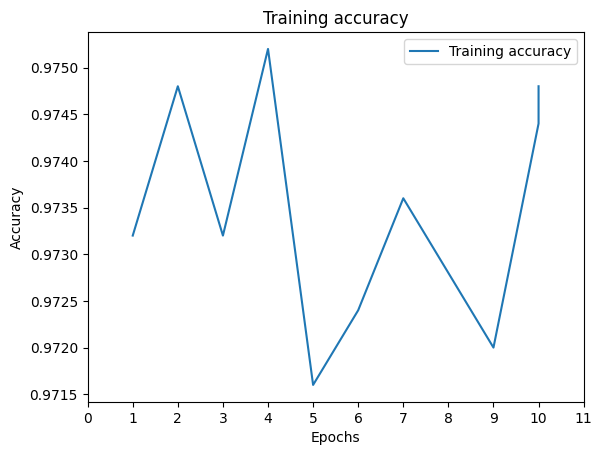

In [145]:
import matplotlib.pyplot as plt
#print(trainer.state.log_history)
# Keep track of train and evaluate loss.
accuracy_history = {'eval_accuracy':[], 'epoch':[]}

eval_accuracy=[]
epoch=[]
# Loop through each log history.
for log_history in trainer.state.log_history:
    if 'eval_loss' in log_history.keys():  
        if 'eval_accuracy' in log_history.keys():
            eval_accuracy.append(log_history['eval_accuracy'])
        if 'epoch' in log_history.keys():
            epoch.append(log_history['epoch'])

epochs = range(1, 12)
# print(epoch)
# print(eval_accuracy)
# Plot and label the training and validation loss values
plt.plot(epoch, eval_accuracy, label='Training accuracy')
#plt.plot(epochs, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
 
# Set the tick locations
plt.xticks(np.arange(0, 12, 1))
 
# Display the plot
plt.legend(loc='best')
plt.show()        
# use_xlabel='Train Steps', use_ylabel='Values', magnify=2)

In [146]:
trainer.predict(tokenized_ds_test)

PredictionOutput(predictions=array([[ 3.2321768, -3.2021163],
       [ 2.57859  , -2.5716581],
       [ 2.85563  , -2.824042 ],
       ...,
       [-1.5577774,  1.5474468],
       [-1.8843985,  1.9158603],
       [-2.1470082,  2.1766615]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 1]), metrics={'test_loss': 0.2339746356010437, 'test_accuracy': 0.93276, 'test_f1': 0.932977154020972, 'test_runtime': 717.3406, 'test_samples_per_second': 34.851, 'test_steps_per_second': 2.179})

In [ ]:
%pwd

In [ ]:
# from tqdm.auto import tqdm
# import evaluate
# progress_bar = tqdm(range(num_training_steps))

# model.train()
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for batch in temp_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         loss = outputs.loss
#         running_loss += loss.item()
#         loss.backward()

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)
#     running_loss /= len(temp_dataloader)
#     print('Evaluation Loss: %.3f '%(running_loss))

In [ ]:
# import evaluate

# #evaluate.list_evaluation_modules()
# metric = evaluate.load("accuracy")
# model.eval()
# for batch in temp_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     with torch.no_grad():
#         outputs = model(**batch)

#     logits = outputs.logits
#     predictions = torch.argmax(logits, dim=-1)
#     metric.add_batch(predictions=predictions, references=batch["labels"])

# metric.compute()

In [ ]:
#To do all preprocessing you specify some parameters in the encod_plus() method of the tokenizer
from os import truncate

encoding = tokenizer.encode_plus(
  example,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation=True
)

encoding.keys()
#The tokens ids list
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]
#The attentions masked tokens
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']
#let's see how the sentence is tokenized with bert tokenizer
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


In [ ]:
#process tokenized datasets
from datasets import ClassLabel, Value
def process_tokenized_datasets(tokenized_ds):
  tokenized_ds = tokenized_ds.remove_columns(["text"])
  tokenized_ds = tokenized_ds.rename_column("label", "labels")
  new_features = tokenized_ds.features.copy()
  new_features["labels"] = Value("float")
  tokenized_ds = tokenized_ds.cast(new_features)
  tokenized_ds.set_format("torch")
  tokenized_ds.column_names
  return tokenized_ds

tokenized_ds_train_processed = process_tokenized_datasets(tokenized_ds_train)
tokenized_ds_validation_processed = process_tokenized_datasets(tokenized_ds_validation)
tokenized_ds_test_processed = process_tokenized_datasets(tokenized_ds_test)
tokenized_ds_temp_processed = process_tokenized_datasets(tokenized_ds_temp)
print(tokenized_ds_train_processed['labels'])
print(tokenized_ds_validation_processed)
print(tokenized_ds_test_processed)
print(tokenized_ds_temp_processed)

In [ ]:
#create dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_ds_train_processed, batch_size=8, collate_fn=data_collator
)
validation_dataloader = DataLoader(
    tokenized_ds_validation_processed, batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_ds_test_processed, batch_size=8, collate_fn=data_collator
)
temp_dataloader = DataLoader(
    tokenized_ds_temp_processed, batch_size=8, collate_fn=data_collator
)
print(validation_dataloader)

In [ ]:
#dataloader info
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

In [ ]:
#model output
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)
print(outputs)

In [ ]:
#change the optimizer to PyTorch AdamW implementation
from transformers import AdamW
import torch


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
#get scheduler
from transformers import get_scheduler

num_epochs = 3
#num_training_steps = num_epochs * len(train_dataloader)
#num_training_steps = num_epochs
num_training_steps = num_epochs * len(temp_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

In [ ]:
#The training loop

import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

In [ ]:
#process features datatypes
def process_feture_type_tokenized_datasets(tokenized_ds):
    new_features = tokenized_ds.features.copy()
    new_features["label"] = Value("float")
    tokenized_ds = tokenized_ds.cast(new_features)
    tokenized_ds.set_format("torch")
    tokenized_ds.column_names
    return tokenized_ds

tokenized_ds_train2 = process_feture_type_tokenized_datasets(tokenized_ds_train)
tokenized_ds_validation2 = process_feture_type_tokenized_datasets(tokenized_ds_validation)
tokenized_ds_test2 = process_feture_type_tokenized_datasets(tokenized_ds_test)
tokenized_ds_temp2 = process_feture_type_tokenized_datasets(tokenized_ds_temp)
